<a href="https://colab.research.google.com/github/nsriniva/DS-Unit-2-Kaggle-Challenge/blob/master/module4-classification-metrics/LS_DS_224_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [ ] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv', na_values=[0, -2.000000e-08]), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv')).set_index('id')

# Read test_features.csv & sample_submission.csv
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv', na_values=[0, -2.000000e-08], index_col='id')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [3]:
train.isna().sum()

amount_tsh               41638
date_recorded                0
funder                    4412
gps_height               20437
installer                 4432
longitude                 1812
latitude                  1812
wpt_name                     0
num_private              58642
basin                        0
subvillage                 371
region                       0
region_code                  0
district_code               23
lga                          0
ward                         0
population               21380
public_meeting            3333
recorded_by                  0
scheme_management         3877
scheme_name              28165
permit                    3056
construction_year        20708
extraction_type              0
extraction_type_group        0
extraction_type_class        0
management                   0
management_group             0
payment                      0
payment_type                 0
water_quality                0
quality_group                0
quantity

In [4]:
def wrangle(X):
  # Make a copy
  X = X.copy()

  # Drop high cardinality cols
  high_card_cols = [col for col in X.select_dtypes('object').columns
                    if X[col].nunique() > 100]

  X.drop(columns=high_card_cols, inplace=True)

  # Drop repeated columns
  cols = ['extraction_type_group', 'quantity']
  X.drop(columns=cols, inplace=True)


  return X

In [5]:
train = wrangle(train)

test = wrangle(test)

In [6]:
# Split TV / FM
target = 'status_group'
y = train[target]
X = train.drop(columns=[target])

# Train-val split
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=0.8, random_state=42)

# Sanity check
assert len(X_train) + len(X_val) == len(X)

In [7]:
print('Baseline Accuracy:', y_train.value_counts(normalize=True).max())

Baseline Accuracy: 0.5425829668132747


In [8]:
%%time

model = make_pipeline(OrdinalEncoder(),
                      SimpleImputer(),
                      RandomForestClassifier(n_estimators=50, n_jobs = -1, random_state=42)
                      )
model.fit(X_train, y_train)
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val))

Training Accuracy: 0.9945074601738252
Validation Accuracy: 0.8052188552188552
CPU times: user 9.12 s, sys: 199 ms, total: 9.32 s
Wall time: 7.53 s


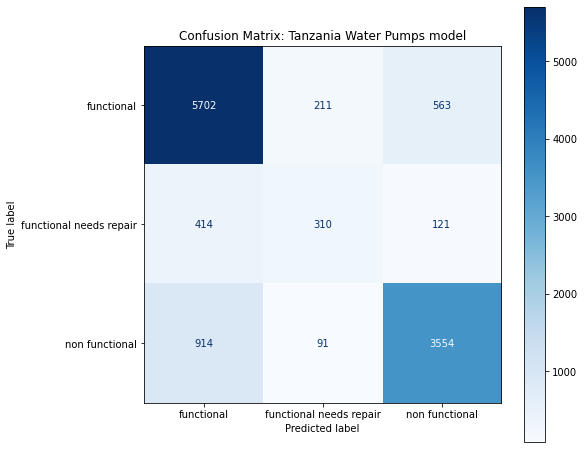

In [17]:
# Plot the decision matrix
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1,figsize=(8,8))

ax.set_title('Confusion Matrix: Tanzania Water Pumps model')

plot_confusion_matrix(model,
                      X_val,
                      y_val,
                      values_format = '.0f',
                      cmap=plt.cm.Blues, ax=ax
                     );




In [12]:
y_pred_proba = model.predict_proba(X_val)[:,-1]
y_pred_proba

array([1. , 0.3, 0. , ..., 0. , 0. , 0.4])

In [14]:
print(classification_report(y_val, model.predict(X_val)))

                         precision    recall  f1-score   support

             functional       0.81      0.88      0.84      6476
functional needs repair       0.51      0.37      0.43       845
         non functional       0.84      0.78      0.81      4559

               accuracy                           0.81     11880
              macro avg       0.72      0.68      0.69     11880
           weighted avg       0.80      0.81      0.80     11880

